In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
style.use('default') or plt.style.use('default')


In [3]:
# Read in grounding line

dfGL = pd.read_csv("/Users/clara.henry/Documents/Derwael/Data/GroundingLine.csv")

points = np.column_stack((list(dfGL["Points:0"])[::10], list(dfGL["Points:1"])[::10]))

alpha = 0.95 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

hull_pts = hull_pts

for i in range(len(hull_pts[0])):
    hull_pts[0][i] = hull_pts[0][i]/1000
    hull_pts[1][i] = hull_pts[1][i]/1000


/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


In [4]:
# Read in csv files

Sims = ['n3E0.5dsdt50Time3405', 'n4E1.8dsdt50Time3405']
LowerSurf = {}

for i in Sims:
    LowerSurf[i] = pd.read_csv('../Simulations/DerwaelSimulations/LowerSurface/' + str(i) + '/LowerSurface.csv', sep=",")


In [5]:
LowerSurf[Sims[0]]



,groundedmask,velocity:0,velocity:1,velocity:2,Points:0,Points:1,Points:2
0,-1,38.43600,122.910000,-0.623540,997590.0,1933400.0,-208.24
1,-1,32.98700,126.670000,-0.617660,997590.0,1935400.0,-204.51
2,-1,23.16300,134.170000,-0.522040,997590.0,1939600.0,-196.63
3,-1,17.34200,137.950000,-0.038811,997590.0,1941800.0,-190.43
4,-1,44.81700,115.610000,-0.869380,997590.0,1929600.0,-213.45
...,...,...,...,...,...,...,...
10582,1,-0.97487,0.178840,0.005380,955200.0,1942100.0,-109.41
10583,1,-1.18270,0.036809,0.005626,954610.0,1941500.0,-108.35
10584,1,-0.36382,-0.282220,-0.000161,957690.0,1940000.0,-125.29
10585,1,-0.33984,-0.084464,0.000715,957830.0,1940900.0,-123.20


In [6]:
# Calculate the velocity magnitude

for i in Sims:
    LowerSurf[i]['vel mag'] = [0]*len(LowerSurf[i])
    for j in range(len(LowerSurf[i])):
        LowerSurf[i]['vel mag'][j] = np.sqrt(LowerSurf[i]['velocity:0'][j]**2 + LowerSurf[i]['velocity:1'][j]**2)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_51717/200116121.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LowerSurf[i]['vel mag'][j] = np.sqrt(LowerSurf[i]['velocity:0'][j]**2 + LowerSurf[i]['velocity:1'][j]**2)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_51717/200116121.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LowerSurf[i]['vel mag'][j] = np.sqrt(LowerSurf[i]['velocity:0'][j]**2 + LowerSurf[i]['velocity:1'][j]**2)


In [7]:
# Define structured grid

xmin, xmax = min(LowerSurf[Sims[0]]['Points:0']), max(LowerSurf[Sims[0]]['Points:0'])
ymin, ymax = min(LowerSurf[Sims[0]]['Points:1']), max(LowerSurf[Sims[0]]['Points:1'])
dist = 100
nx, ny = int((xmax - xmin)/dist + 1), int((ymax - ymin)/dist + 1)
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
grid_x, grid_y = np.meshgrid(x, y)


In [8]:
# Regrid data

vxRegridded = {}
vyRegridded = {}
vmagRegridded = {}
GroundedRegridded = {}

for i in Sims:
    vxRegridded[i] = scipy.interpolate.griddata((LowerSurf[i]["Points:0"], LowerSurf[i]["Points:1"]), LowerSurf[i]["velocity:0"], (grid_x, grid_y), method='linear')
    vyRegridded[i] = scipy.interpolate.griddata((LowerSurf[i]["Points:0"], LowerSurf[i]["Points:1"]), LowerSurf[i]["velocity:1"], (grid_x, grid_y), method='linear')
    vmagRegridded[i] = scipy.interpolate.griddata((LowerSurf[i]["Points:0"], LowerSurf[i]["Points:1"]), LowerSurf[i]["vel mag"], (grid_x, grid_y), method='linear')
    GroundedRegridded[i] = scipy.interpolate.griddata((LowerSurf[i]["Points:0"], LowerSurf[i]["Points:1"]), LowerSurf[i]["groundedmask"], (grid_x, grid_y), method='linear')
    
    vxRegridded[i][np.where(GroundedRegridded[i]<0.9)] = np.nan
    vyRegridded[i][np.where(GroundedRegridded[i]<0.9)] = np.nan
    vmagRegridded[i][np.where(GroundedRegridded[i]<0.9)] = np.nan
    
    vxRegridded[i] = np.divide(vxRegridded[i], vmagRegridded[i])
    vyRegridded[i] = np.divide(vyRegridded[i], vmagRegridded[i])


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_51717/4103385701.py:6: UserWarning: The following kwargs were not used by contour: 'style'
  CS = ax.contourf(x/1000, y/1000, vmagRegridded[Sims[0]], levels=levels, cmap="GnBu", extend='max', style="sci")


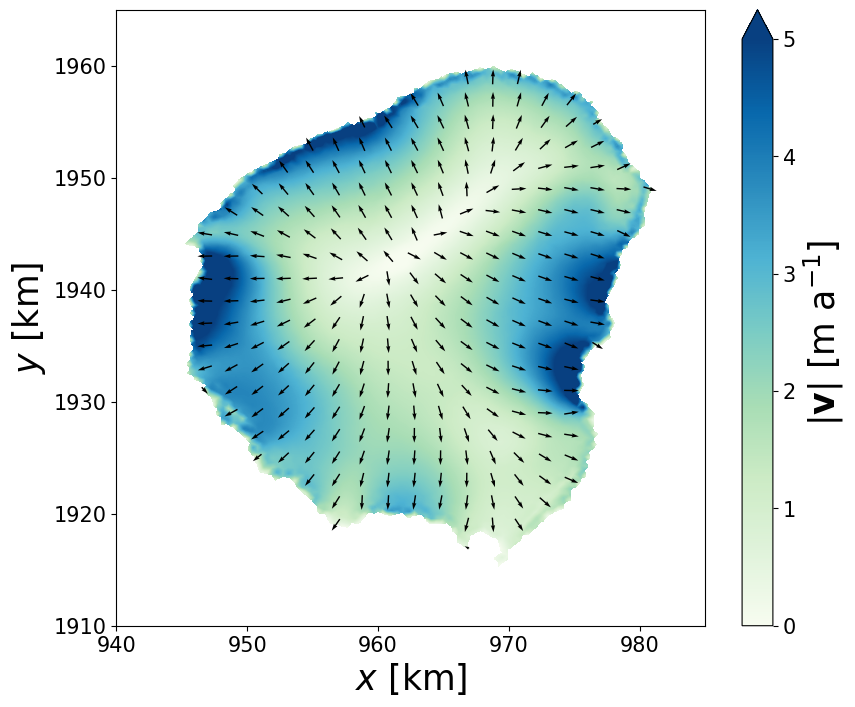

In [9]:
# Plot the n=3 basal velocity field

inter = 20
fig, ax = plt.subplots(1, 1, figsize=(9.5, 8))
levels = np.linspace(0.0, 5, 500)
CS = ax.contourf(x/1000, y/1000, vmagRegridded[Sims[0]], levels=levels, cmap="GnBu", extend='max', style="sci")
plt.xlim(940, 985)
plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0, 1, 2, 3, 4, 5])
cbar.set_label('$|\mathbf{v}|$ [m a$^{-1}$]', rotation=90, size=25)
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[Sims[0]][skip], vyRegridded[Sims[0]][skip], scale=40, pivot='mid')
ax.set_xticks([940, 950, 960, 970, 980])
cbar.ax.tick_params(labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)

fig.savefig('../Figures/n3BasalVelocity.jpg', format='jpg', dpi=700, bbox_inches = "tight")



/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_51717/3652463402.py:6: UserWarning: The following kwargs were not used by contour: 'style'
  CS = ax.contourf(x/1000, y/1000, vmagRegridded[Sims[1]], levels=levels, cmap="viridis", extend='max', style="sci")


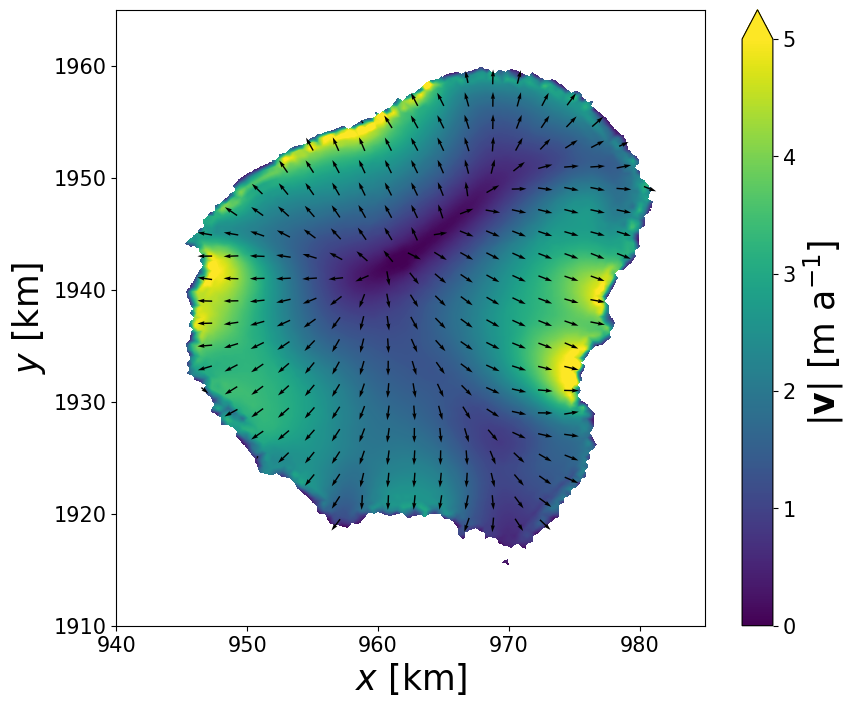

In [10]:
# Plot the n=4 basal velocity field

inter = 20
fig, ax = plt.subplots(1, 1, figsize=(9.5, 8))
levels = np.linspace(0.0, 5, 500)
CS = ax.contourf(x/1000, y/1000, vmagRegridded[Sims[1]], levels=levels, cmap="viridis", extend='max', style="sci")
plt.xlim(940, 985)
plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0, 1, 2, 3, 4, 5])
cbar.set_label('$|\mathbf{v}|$ [m a$^{-1}$]', rotation=90, size=25)
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[Sims[1]][skip], vyRegridded[Sims[1]][skip], scale=40, pivot='mid')
ax.set_xticks([940, 950, 960, 970, 980])
cbar.ax.tick_params(labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)

fig.savefig('../Figures/n4BasalVelocity.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_51717/4131021127.py:6: UserWarning: The following kwargs were not used by contour: 'style'
  CS = ax.contourf(x/1000, y/1000, vmagRegridded[Sims[1]] - vmagRegridded[Sims[0]], levels=levels, cmap="Spectral", extend='both', style="sci")


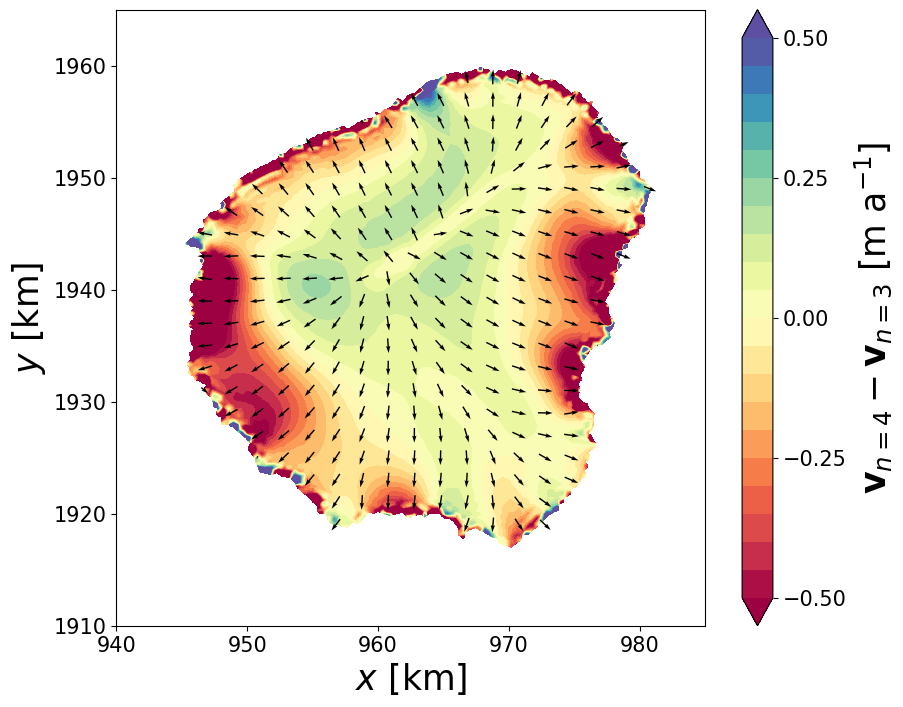

In [13]:
# Plot the n=4 basal velocity field

inter = 20
fig, ax = plt.subplots(1, 1, figsize=(9.5, 8))
levels = np.linspace(-0.5,0.5, 21)
CS = ax.contourf(x/1000, y/1000, vmagRegridded[Sims[1]] - vmagRegridded[Sims[0]], levels=levels, cmap="Spectral", extend='both', style="sci")
plt.xlim(940, 985)
plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[-0.5, -0.25, 0.0, 0.25, 0.5])
cbar.set_label('$\mathbf{v}_{n=4} - \mathbf{v}_{n=3}$ [m a$^{-1}$]', rotation=90, size=25)
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[Sims[1]][skip], vyRegridded[Sims[1]][skip], scale=40, pivot='mid')
ax.set_xticks([940, 950, 960, 970, 980])
cbar.ax.tick_params(labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)

fig.savefig('../Figures/BasalVelocityDiff.jpg', format='jpg', dpi=700, bbox_inches = "tight")
